In [ ]:
# Linear regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [3]:
Rev=pd.read_csv('../data/movie_industry.csv',encoding = "ISO-8859-1")
Rev=Rev[['genre','gross','name','year']]

In [6]:
Mov=pd.read_csv('../data/movie_lense/movies.csv',sep=',')
Rat=pd.read_csv('../data/movie_lense/ratings.csv')
def ext_movname(tlist):
    lst=tlist.copy()
    year=tlist.copy()
    for i in range(len(tlist)):
        raw=tlist[i].rstrip()
        try:
            year[i]=int(raw[-5:-1])
            lst[i]=raw[:-7]
        except:
            year[i]=np.nan
            lst[i]=raw
    return [lst,year]
u=ext_movname(Mov['title'])
Mov['title']=u[0]
Mov['year']=u[1]
CMov=Mov.reset_index(drop=True)
def recorr(string):
    if '(' in string:
        nstr=string.split(' (')[0]
    else:
        nstr=string
    if ',' not in nstr:
        return nstr
    else:
        lst=nstr.split(sep=', ')
        if lst[-1] not in {'The', 'A'}:
            return nstr
        else:
            nlst=lst[:-1]
            new=lst[-1]+' '
            for j in nlst:
                new=new+j
            return new
CMov['title']=CMov['title'].apply(recorr)

In [7]:
def extract_year(time_se):
    return time.localtime(time_se).tm_year
Ye=Rat['timestamp'].apply(extract_year)
Rat['timestamp']=Ye

In [8]:
R_Mov=pd.merge(CMov,Rat,on=['movieId'])
col=list(R_Mov.columns)
col[1]='name'
R_Mov.columns=col
R_Mov=R_Mov[['movieId','name','year','rating']]

In [9]:
M_Rev=pd.merge(R_Mov,Rev,how='inner',on=['name','year'])

In [10]:
Tot_grp=M_Rev.groupby(by=['movieId','name','year','genre','gross'],as_index=False)
Tot=Tot_grp.count()
lg_count=Tot_grp.count()['rating'].apply(np.log)
Tot['lg_count']=lg_count
Tot=Tot.drop(['rating'],axis=1)
mean=Tot_grp.mean()['rating']
Tot['mean']=mean
Tot=Tot.drop(['name','year'],axis=1)
Tot['lg_gross']=Tot['gross'].apply(np.log)
Tot=Tot.drop(['gross'],axis=1)
Tot['Const']=1

In [11]:
# Regression on total
import statsmodels.api as sm

In [12]:
X1=Tot[['lg_count','Const']]
Y1=Tot['lg_gross']
Reg_tot1=sm.OLS(Y1,X1)
Reg_tot1=Reg_tot1.fit()

In [13]:
Reg_tot1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lg_gross   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     3358.
Date:                Sun, 20 Sep 2020   Prob (F-statistic):               0.00
Time:                        12:53:31   Log-Likelihood:                -12235.
No. Observations:                5902   AIC:                         2.447e+04
Df Residuals:                    5900   BIC:                         2.449e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lg_count       0.7496      0.013     57.948      0.000       0.724       0.775
Const         10.8683      0.089    121.967      0.000      10.694      11.043
==============================================================================
Omnibus:                      794.274   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1282.028
Skew:                          -0.928   Prob(JB):                    4.09e-279
Kurtosis:                       4.330   Cond. No.                         25.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
Y2=Reg_tot1.resid
X2=Tot[['mean','Const']]
Reg_tot2=sm.OLS(Y2,X2)
Reg_tot2=Reg_tot2.fit()

Text(0, 0.5, 'log gross with log count regressed away')

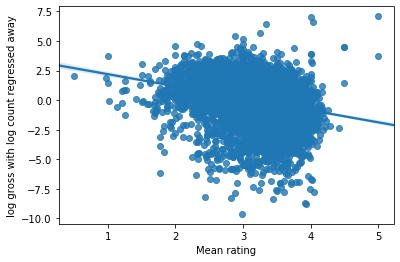

In [28]:
import seaborn as sns
sns.regplot(Tot['mean'], Reg_tot1.resid)
plt.xlabel(r'Mean rating')
plt.ylabel(r'log gross with log count regressed away')

In [22]:
np.corrcoef(Tot['mean'], Reg_tot1.resid)

array([[ 1.        , -0.26011786],
       [-0.26011786,  1.        ]])

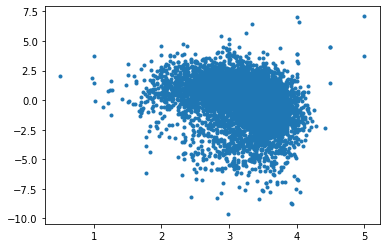

In [21]:
plt.plot(Tot['mean'], Reg_tot1.resid, '.')

In [16]:
Reg_tot2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     428.2
Date:                Sun, 20 Sep 2020   Prob (F-statistic):           6.96e-92
Time:                        12:53:48   Log-Likelihood:                -12028.
No. Observations:                5902   AIC:                         2.406e+04
Df Residuals:                    5900   BIC:                         2.407e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mean          -1.0171      0.049    -20.692      0.000      -1.113      -0.921
Const          3.2089      0.157     20.445      0.000       2.901       3.517
==============================================================================
Omnibus:                      910.441   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1709.401
Skew:                          -0.968   Prob(JB):                         0.00
Kurtosis:                       4.789   Cond. No.                         22.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# Collect the testing informations
Info_regtot1=pd.DataFrame()
Info_regtot1['group']=['Total','Total','Total','Total']
Info_regtot1['params']=['lg_count','Const1','mean','Const2']
Info_regtot1['Coefs']=list(Reg_tot1.params)+list(Reg_tot2.params)
Info_regtot1['t']=list(Reg_tot1.tvalues)+list(Reg_tot2.tvalues)
Info_regtot1['p>|t|']=list(Reg_tot1.pvalues)+list(Reg_tot2.pvalues)

In [18]:
# Now for different genres
genres=list(Tot.groupby('genre').count().index)
for i in genres:
    df=pd.DataFrame()
    df['group']=[i,i,i,i]
    X01=Tot[['lg_count','Const']][Tot.genre==i]
    Y01=Tot['lg_gross'][Tot.genre==i]
    Reg_tot01=sm.OLS(Y01,X01)
    Reg_tot01=Reg_tot01.fit()
    Y02=Reg_tot01.resid
    X02=Tot[['mean','Const']][Tot.genre==i]
    Reg_tot02=sm.OLS(Y02,X02)
    Reg_tot02=Reg_tot02.fit()   
    df['params']=['lg_count','Const1','mean','Const2']
    df['Coefs']=list(Reg_tot01.params)+list(Reg_tot02.params)
    df['t']=list(Reg_tot01.tvalues)+list(Reg_tot02.tvalues)
    df['p>|t|']=list(Reg_tot01.pvalues)+list(Reg_tot02.pvalues)
    Info_regtot1=pd.concat([Info_regtot1,df],axis=0)

/home/sbg/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/home/sbg/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/home/sbg/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/sbg/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/sbg/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [19]:
Info_regtot1

,group,params,Coefs,t,p>|t|
0,Total,lg_count,7.495918e-01,57.947905,0.000000e+00
1,Total,Const1,1.086829e+01,121.967072,0.000000e+00
2,Total,mean,-1.017086e+00,-20.692327,6.962488e-92
3,Total,Const2,3.208944e+00,20.445343,8.058718e-90
0,Action,lg_count,7.070113e-01,28.170918,1.952697e-133
...,...,...,...,...,...
3,War,Const2,3.068077e-14,NaN,NaN
0,Western,lg_count,-1.858845e+00,-0.000000,NaN
1,Western,Const1,2.298115e+01,0.000000,NaN
2,Western,mean,-3.405539e-15,-0.000000,NaN


In [165]:
Info_regtot1.to_csv('Results_reg.csv')